# Name: Luke Pratley

# Testing Basic UNet

In [1]:
%load_ext nb_black
import tensorflow.keras 
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import PIL
import math

import sys
import glob

from sklearn.model_selection import train_test_split

sys.path.append('..')

import building_road_segmentation.unet_factory as unet_factory
import building_road_segmentation.optimization_factory as optimization_factory
from building_road_segmentation.data_generator import read_data

<IPython.core.display.Javascript object>

In [2]:
image_dir =  glob.glob("..\\..\\Brainstation-Notes\\Capstone Project\\final_images_small\\*")
mask_dir =  glob.glob("..\\..\\Brainstation-Notes\\Capstone Project\\final_masks_small\\*")
for p in range(len(image_dir)):
    s1 = image_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.png', '')
    s2 = mask_dir[p].split('\\')[-1].replace('RGB-PanSharpen_', '').replace('.npy', '')
    assert s1 == s2

<IPython.core.display.Javascript object>

In [3]:
train_image_dir, test_image_dir, train_mask_dir, test_mask_dir = train_test_split(image_dir, mask_dir, test_size=0.3)

<IPython.core.display.Javascript object>

In [4]:
train_data = read_data(train_image_dir, train_mask_dir, batch_size=64)
test_data = read_data(test_image_dir, test_mask_dir, batch_size=128)

<IPython.core.display.Javascript object>

In [41]:
unet_levels = 4
number_of_categories = 3
unet_model = unet_factory.BasicUnet(number_of_categories=number_of_categories,
                                    unet_levels=unet_levels,
                                    number_of_start_kernels=32,
                                    kernel_shape=(3, 3),
                                    activation='relu',
                                    pooling_amount=2,
                                    dropout_rate=0.2)

<IPython.core.display.Javascript object>

In [42]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
train_iou_metric = tf.keras.metrics.MeanIoU(num_classes=3)

<IPython.core.display.Javascript object>

In [43]:
trainer = optimization_factory.Trainer(unet_model,loss_fn, optimizer,train_acc_metric, test_acc_metric,)# train_metrics=[('iou', train_iou_metric)])

<IPython.core.display.Javascript object>

In [44]:
trainer.fit(train_data, test_data, epochs = 50, interval=1)

Epoch: 0
1536/1435 [================================] - 4s 3ms/step - val_acc: 0.2780
Epoch: 1
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5244
Epoch: 2
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5244
Epoch: 3
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5244
Epoch: 4
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5244
Epoch: 5
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5263
Epoch: 6
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5267
Epoch: 7
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5422
Epoch: 8
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5551
Epoch: 9
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.5848
Epoch: 10
1536/1435 [================================] - 2s 1ms/step - val_acc: 0.6003
Epoch: 11
1536/1435 [================================

<IPython.core.display.Javascript object>

In [45]:
fitted_model = trainer.model

<IPython.core.display.Javascript object>

In [46]:
X_test = np.array([np.array(PIL.Image.open(im)).astype(float) for im in test_image_dir])

<IPython.core.display.Javascript object>

In [47]:
y_test = np.array([
            np.load(file_name)
               for file_name in test_mask_dir])

<IPython.core.display.Javascript object>

In [48]:
def plot_result(X_test, y_test, y_pred):
    fig, ax = plt.subplots(2, 4, figsize=(20, 10), sharex=True, sharey=True)
    ax[0, 0].imshow(X_test.astype(int))
    ax[1, 0].imshow(np.sum(y_test[:, :, :2], axis=2), vmin = 0)
    ax[1, 1].imshow(y_test[ :, :, 0], vmin = 0)
    ax[1, 2].imshow(y_test[:, :, 1], vmin = 0)
    ax[1, 3].imshow(y_test[:, :, 2], vmin = 0)
    ax[0, 1].imshow(y_pred[:, :, 0], vmin = 0)
    ax[0, 2].imshow(y_pred[:, :, 1], vmin = 0)
    ax[0, 3].imshow(y_pred[:, :, 2], vmin = 0)

<IPython.core.display.Javascript object>

In [49]:
y_pred = fitted_model.predict(np.array([np.array(PIL.Image.open(im)).astype(float)/255. for im in test_image_dir]))
y_pred = np.where(y_pred > 0.5, 1, 0)

<IPython.core.display.Javascript object>

In [50]:
train_iou_metric.update_state(y_pred, y_test)
tf.print(train_iou_metric.result())
train_iou_metric.reset_state()

0.569148421


<IPython.core.display.Javascript object>

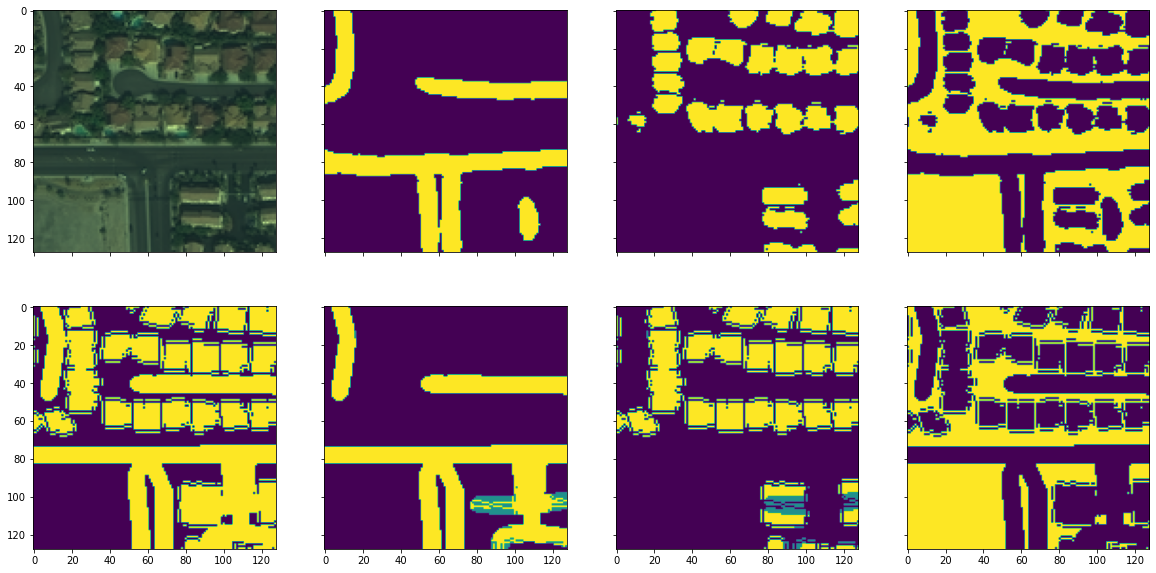

<IPython.core.display.Javascript object>

In [53]:
k = 50
plot_result(X_test[k], y_test[k], y_pred[k])